In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

c:\Users\Bhavya\.conda\envs\fy_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Bhavya\.cache\kagglehub\datasets\aryashah2k\breast-ultrasound-images-dataset\versions\1


In [2]:
import os

data_dir = "C:\\Users\\Bhavya\\.cache\\kagglehub\\datasets\\aryashah2k\\breast-ultrasound-images-dataset\\versions\\1\\Dataset_BUSI_with_GT"

print("Classes: ", os.listdir(data_dir))

Classes:  ['benign', 'malignant', 'normal']


In [3]:
print("benign samples:", len(os.listdir(os.path.join(data_dir, "benign"))))
print("malignant samples:", len(os.listdir(os.path.join(data_dir, "malignant"))))
print("normal samples:", len(os.listdir(os.path.join(data_dir, "normal"))))

benign samples: 891
malignant samples: 421
normal samples: 266


In [4]:
list_scan = []
list_mask = []

for images in os.listdir(os.path.join(data_dir, "benign")):
    if images.endswith(").png"):
        list_scan.append(images)
    else:
        list_mask.append(images)

for images in os.listdir(os.path.join(data_dir, "malignant")):
    if images.endswith(").png"):
        list_scan.append(images)
    else:
        list_mask.append(images)

for images in os.listdir(os.path.join(data_dir, "normal")):
    if images.endswith(").png"):
        list_scan.append(images)
    else:
        list_mask.append(images)

In [5]:
print(list_scan[:5])
print(list_mask[:5])

print(len(list_scan))
print(len(list_mask))

['benign (1).png', 'benign (10).png', 'benign (100).png', 'benign (101).png', 'benign (102).png']
['benign (1)_mask.png', 'benign (10)_mask.png', 'benign (100)_mask.png', 'benign (100)_mask_1.png', 'benign (101)_mask.png']
780
798


In [6]:
list_mask_two = []

for images in list_mask:
    if images.endswith("1.png"):
        list_mask_two.append(images)

print(len(list_mask_two))
print(list_mask_two[:5])

17
['benign (100)_mask_1.png', 'benign (163)_mask_1.png', 'benign (173)_mask_1.png', 'benign (181)_mask_1.png', 'benign (195)_mask_1.png']


In [7]:
data_dict = {}

folders = ["benign", "malignant", "normal"]

for folder in folders:
    folder_path = os.path.join(data_dir, folder)

    for fname in os.listdir(folder_path):
        # extract number inside ()
        start = fname.find("(")
        end = fname.find(")")
        image_id = fname[start+1:end]

        # make unique key
        unique_id = folder + "_" + image_id

        # initialize if not exists
        if unique_id not in data_dict:
            data_dict[unique_id] = {
                "folder": folder,
                "image": None,
                "masks": []
            }

        # classify file
        if "_mask" in fname:
            data_dict[unique_id]["masks"].append(fname)
        else:
            data_dict[unique_id]["image"] = fname




In [8]:
print(data_dict[list(data_dict.keys())[2]])


{'folder': 'benign', 'image': 'benign (100).png', 'masks': ['benign (100)_mask.png', 'benign (100)_mask_1.png']}


In [9]:
import numpy as np
from PIL import Image
import os

# pick one sample
key = list(data_dict.keys())[0]
sample = data_dict[key]

folder = sample["folder"]
mask_files = sample["masks"]

# build full paths for masks
mask_paths = [
    os.path.join(data_dir, folder, m) for m in mask_files
]

# load first mask to get shape
first_mask = Image.open(mask_paths[0]).convert("L")
final_mask = np.zeros(np.array(first_mask).shape, dtype=np.uint8)

# merge all masks
for mpath in mask_paths:
    mask = Image.open(mpath).convert("L")
    mask_arr = np.array(mask)

    # binarize
    mask_arr = (mask_arr > 0).astype(np.uint8)

    # OR operation
    final_mask = np.logical_or(final_mask, mask_arr)

# convert boolean to 0/1
final_mask = final_mask.astype(np.uint8)

# verification
print("Key:", key)
print("Number of masks:", len(mask_files))
print("Final mask shape:", final_mask.shape)
print("Unique values:", np.unique(final_mask))


Key: benign_1
Number of masks: 1
Final mask shape: (471, 562)
Unique values: [0 1]


In [10]:
import torch
from torch.utils.data import Dataset

class BUSIDataset(Dataset):
    def __init__(self, data_dict, data_dir):
        self.data_dict = data_dict
        self.data_dir = data_dir
        self.keys = list(data_dict.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        sample = self.data_dict[key]

        folder = sample["folder"]
        image_name = sample["image"]
        mask_names = sample["masks"]

        # load image
        img_path = os.path.join(self.data_dir, folder, image_name)
        image = Image.open(img_path).convert("L")
        image = image.resize((256, 256))
        image = np.array(image) / 255.0

        # merge masks FIRST
        final_mask = np.zeros((256, 256), dtype=np.uint8)

        for m in mask_names:
            mask_path = os.path.join(self.data_dir, folder, m)
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize((256, 256))
            mask = np.array(mask)
            mask = (mask > 0).astype(np.uint8)

            final_mask = np.logical_or(final_mask, mask)

        final_mask = final_mask.astype(np.uint8)

        # AUGMENTATION (correct place)
        import random
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            final_mask = np.fliplr(final_mask).copy()


        if random.random() > 0.5:
            image = np.flipud(image).copy()
            final_mask = np.flipud(final_mask).copy()


        # to tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        final_mask = torch.tensor(final_mask, dtype=torch.float32).unsqueeze(0)

        return image, final_mask


In [11]:
dataset = BUSIDataset(data_dict, data_dir)
img, mask = dataset[0]

print(img.shape)
print(mask.shape)
print(torch.unique(mask))


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
tensor([0., 1.])


In [12]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [13]:
block = DoubleConv(1, 64)
x = torch.randn(1, 1, 512, 512)
y = block(x)
print(y.shape)


torch.Size([1, 64, 512, 512])


In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)

        # use ResNet layers
        self.layer0 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )                 # -> 64, 128x128
        self.layer1 = nn.Sequential(
            resnet.maxpool,
            resnet.layer1
        )                 # -> 64, 64x64
        self.layer2 = resnet.layer2  # -> 128, 32x32
        self.layer3 = resnet.layer3  # -> 256, 16x16
        self.layer4 = resnet.layer4  # -> 512, 8x8

    def forward(self, x):
        # x: [B,1,H,W] → repeat to 3 channels
        x = x.repeat(1, 3, 1, 1)

        e1 = self.layer0(x)
        e2 = self.layer1(e1)
        e3 = self.layer2(e2)
        e4 = self.layer3(e3)
        e5 = self.layer4(e4)

        return e1, e2, e3, e4, e5


In [15]:
enc = ResNet18Encoder()
x = torch.randn(1, 1, 256, 256)

e1, e2, e3, e4, e5 = enc(x)

print(e1.shape)
print(e2.shape)
print(e3.shape)
print(e4.shape)
print(e5.shape)



c:\Users\Bhavya\.conda\envs\fy_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bhavya\.conda\envs\fy_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Bhavya/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.72MB/s]


torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])


In [16]:
class UNetBottleneck(nn.Module):
    def __init__(self):
        super(UNetBottleneck, self).__init__()
        self.bottleneck = DoubleConv(512, 1024)

    def forward(self, x):
        return self.bottleneck(x)


In [17]:
bottleneck = UNetBottleneck()

x = torch.randn(1, 512, 64, 64)
y = bottleneck(x)

print(y.shape)


torch.Size([1, 1024, 64, 64])


In [18]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [19]:
dec = DecoderBlock(1024, 512, 512)

x = torch.randn(1, 1024, 64, 64)
skip = torch.randn(1, 512, 128, 128)

y = dec(x, skip)
print(y.shape)


torch.Size([1, 512, 128, 128])


In [24]:
class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = ResNet18Encoder()

        self.dec4 = DecoderBlock(512, 256, 256)  # 8 → 16
        self.dec3 = DecoderBlock(256, 128, 128)  # 16 → 32
        self.dec2 = DecoderBlock(128, 64, 64)    # 32 → 64
        self.dec1 = DecoderBlock(64, 64, 64)     # 64 → 128

        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.up_final = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)


    def forward(self, x):
        e1, e2, e3, e4, e5 = self.encoder(x)

        d4 = self.dec4(e5, e4)   # 8 → 16
        d3 = self.dec3(d4, e3)   # 16 → 32
        d2 = self.dec2(d3, e2)   # 32 → 64
        d1 = self.dec1(d2, e1)   # 64 → 128

        d0 = self.up_final(d1)   # 128 → 256

        return self.out_conv(d0)



In [ ]:
model = ResNetUNet()
x = torch.randn(1, 1, 256, 256)
y = model(x)

print(y.shape)

torch.Size([1, 1, 256, 256])


In [27]:
import torch

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)

    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return 1 - dice

import torch.nn.functional as F

def dice_bce_loss(pred, target):
    dice = dice_loss(pred, target)
    bce = F.binary_cross_entropy_with_logits(pred, target)
    return dice + bce


In [28]:
pred = torch.randn(1, 1, 512, 512)
target = torch.randint(0, 2, (1, 1, 512, 512)).float()

loss = dice_loss(pred, target)
print(loss.item())


0.49969059228897095


In [29]:
from torch.utils.data import DataLoader
import torch.optim as optim

loader = DataLoader(dataset, batch_size=1, shuffle=True)

model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

images, masks = next(iter(loader))

optimizer.zero_grad()

outputs = model(images)
loss = dice_loss(outputs, masks)

loss.backward()
optimizer.step()

print("Loss:", loss.item())


Loss: 0.9703760743141174


In [30]:
import torch
print(torch.cuda.is_available())
print(next(model.parameters()).device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)

True
cpu
cuda:0


In [32]:
from torch.utils.data import DataLoader
import torch.optim as optim

loader = DataLoader(dataset, batch_size=1, shuffle=True)

model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30

for epoch in range(num_epochs):
    epoch_loss = 0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = dice_bce_loss(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Dice Loss: {avg_loss:.4f}")


Epoch [1/30] - Dice Loss: 0.6267
Epoch [2/30] - Dice Loss: 0.5559
Epoch [3/30] - Dice Loss: 0.5112
Epoch [4/30] - Dice Loss: 0.4809
Epoch [5/30] - Dice Loss: 0.4702
Epoch [6/30] - Dice Loss: 0.4417
Epoch [7/30] - Dice Loss: 0.4525
Epoch [8/30] - Dice Loss: 0.4214
Epoch [9/30] - Dice Loss: 0.4330
Epoch [10/30] - Dice Loss: 0.4071
Epoch [11/30] - Dice Loss: 0.3985
Epoch [12/30] - Dice Loss: 0.4241
Epoch [13/30] - Dice Loss: 0.3926
Epoch [14/30] - Dice Loss: 0.3937
Epoch [15/30] - Dice Loss: 0.3859
Epoch [16/30] - Dice Loss: 0.4166
Epoch [17/30] - Dice Loss: 0.4095
Epoch [18/30] - Dice Loss: 0.4671
Epoch [19/30] - Dice Loss: 0.3888
Epoch [20/30] - Dice Loss: 0.3759
Epoch [21/30] - Dice Loss: 0.3713
Epoch [22/30] - Dice Loss: 0.3507
Epoch [23/30] - Dice Loss: 0.3352
Epoch [24/30] - Dice Loss: 0.3007
Epoch [25/30] - Dice Loss: 0.3529
Epoch [26/30] - Dice Loss: 0.4148
Epoch [27/30] - Dice Loss: 0.2823
Epoch [28/30] - Dice Loss: 0.2787
Epoch [29/30] - Dice Loss: 0.2760
Epoch [30/30] - Dice Lo

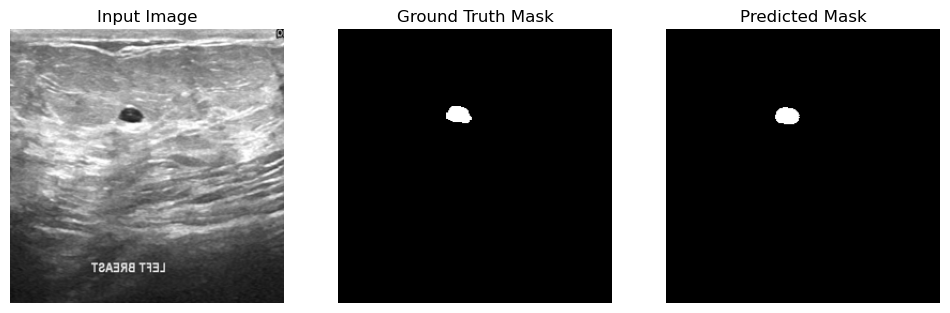

In [33]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    image, mask = dataset[0]

    image = image.unsqueeze(0).to(device)
    pred = model(image)

    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

image = image.cpu().squeeze().numpy()
mask = mask.squeeze().numpy()
pred = pred.cpu().squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred, cmap="gray")
plt.axis("off")

plt.show()


In [34]:
model.eval()


ResNetUNet(
  (encoder): ResNet18Encoder(
    (layer0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [35]:
import torch

def dice_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    return (2 * intersection + eps) / (pred.sum() + target.sum() + eps)

def iou_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)

def precision_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    return (tp + eps) / (tp + fp + eps)

def recall_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float()
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()
    return (tp + eps) / (tp + fn + eps)

def specificity_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float()
    tn = ((1 - pred) * (1 - target)).sum()
    fp = (pred * (1 - target)).sum()
    return (tn + eps) / (tn + fp + eps)


In [36]:
import random

N = 20
indices = random.sample(range(len(dataset)), N)

dice_list, iou_list = [], []
prec_list, rec_list, spec_list = [], [], []

with torch.no_grad():
    for idx in indices:
        image, mask = dataset[idx]

        image = image.unsqueeze(0).to(device)
        mask = mask.to(device)

        pred = torch.sigmoid(model(image))

        dice_list.append(dice_score(pred, mask).item())
        iou_list.append(iou_score(pred, mask).item())
        prec_list.append(precision_score(pred, mask).item())
        rec_list.append(recall_score(pred, mask).item())
        spec_list.append(specificity_score(pred, mask).item())


In [38]:
print("Baseline UNet Evaluation (N=30)")
print(f"Dice Score      : {sum(dice_list)/N:.4f}")
print(f"IoU (Jaccard)   : {sum(iou_list)/N:.4f}")
print(f"Precision       : {sum(prec_list)/N:.4f}")
print(f"Recall          : {sum(rec_list)/N:.4f}")
print(f"Specificity     : {sum(spec_list)/N:.4f}")


Baseline UNet Evaluation (N=30)
Dice Score      : 0.7485
IoU (Jaccard)   : 0.6920
Precision       : 0.9619
Recall          : 0.7186
Specificity     : 0.9983


In [1]:
torch.save(model.state_dict(), "resnet_unet_busi_256.pth")



NameError: name 'torch' is not defined